**Etude de faisaibilité IMAGE**
-----------------
Ce notebook a objectif d'étudier la faisabilité de classifier la photo associée à chaque produit selon sa catégorie.


On procéde en 3 étapes :
- **Analyse et prétraitement nécessaires des données**
- **Vectorisation numérique des données par plusieurs méthodes** : SIFT avec VBOW, VGG16, ResNet50, InceptionV3, EfficientNetB0
- **Segmentation non supervisée de ces vecteurs**
- **Mesure de la similarité entre les segments et les catégories prédéfinies**


Nous pourrons comparer ces résultats à ceux de la partie vision avant de décider quelle méthode utiliser pour la partie de classification supervisée.

# Imports

In [241]:
# Imports basiques
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
from gc import collect
from collections import Counter

# Imports pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Classes pour le clustering et les métriques
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Librairies et classes pour le traitement des images
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

In [143]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

# **Chargement des données nettoyées**

In [144]:
image_df = pd.read_pickle('flipkart_cleaned.pkl')
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.4+ KB
None


# **Analyse et prétraitement des données**

Lors de l'analyse pré-exploratoire, on a gardé la colonne `image` qui contient les noms de fichiers avec extension.<br>
Regardons l'analyse sur la taille des images présentes dans le dataset.

In [145]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

Je définis une fonction pour extraire les caractéristiques des images dont la largeur, la hauteur, le nombre de canaux et la taille en octets:

In [146]:
def extract_img_features(images, path):
    # Crée des listes pour stocker les caractéristiques des images
    img_height = []
    img_width = []
    img_channels = []
    img_size = []

    # Itère sur la séquence contenant les images pour récupérer les caractéristiques de chaque image
    for img in images:
        image = cv2.imread(path + img, cv2.IMREAD_COLOR)
        img_height.append(image.shape[0])
        img_width.append(image.shape[1])
        img_channels.append(image.shape[2])
        img_size.append(image.size)
        
    # Retourne un DataFrame contenant les caractéristiques des images
    return pd.DataFrame({'height': img_height, 'width': img_width, 'channels': img_channels, 'size': img_size})

Je modifie le dataframe pour ajouter les caractéristiques extraites:

In [147]:
image_df = pd.concat([image_df, extract_img_features(image_df['image'], path)], axis=1)
print(image_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   image     1050 non-null   object  
 1   class     1050 non-null   category
 2   height    1050 non-null   int64   
 3   width     1050 non-null   int64   
 4   channels  1050 non-null   int64   
 5   size      1050 non-null   int64   
dtypes: category(1), int64(4), object(1)
memory usage: 42.2+ KB
None


In [151]:
# Récupère les labels uniques dans une liste
list_labels = list(image_df['class'].unique())
print('Liste des labels :')
print(list_labels)

['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


Afin de comprendre les données extraites, je regarde :
- Les statistiques descriptives des caractéristiques extraites
- Un nuage de points pour visualiser la distribution des caractéristiques LxH de chaque image

In [148]:
# Aperçu des statistiques descriptives des features extraites
print(image_df.select_dtypes(include='int').describe())

             height        width  channels          size
count   1050.000000  1050.000000    1050.0  1.050000e+03
mean    1220.038095  1196.570476       3.0  5.748901e+06
std      744.841368   864.076765       0.0  1.175770e+07
min      160.000000   145.000000       3.0  1.740000e+05
25%      844.000000   747.250000       3.0  2.017125e+06
50%     1100.000000  1100.000000       3.0  3.047550e+06
75%     1360.000000  1214.250000       3.0  4.661820e+06
max    11042.000000  8484.000000       3.0  2.810410e+08


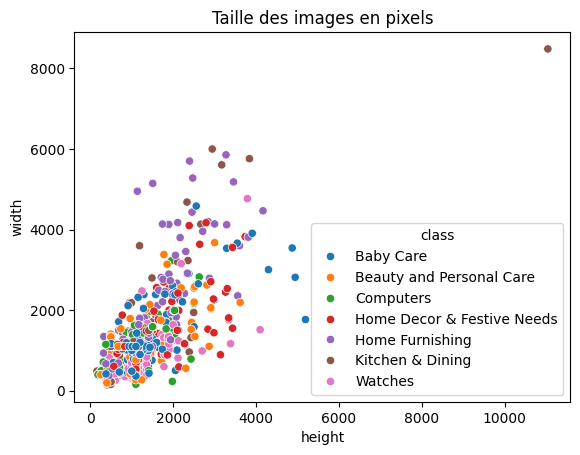

In [149]:
# Crée une figure avec 2 plots en 1 ligne et 2 colonnes
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot de la taille des images
image_df.pipe(sns.scatterplot, x="height", y="width", hue='class', ax=ax[0])
ax[0].title("Répartition des images selon leur dimension Lxh")
ax[0].set_xlabel("Hauteur en pixels")
ax[0].set_ylabel("Largeur en pixels")

# Strip plot de la taille des images
sns.stripplot(x='size', hue='class', data=image_df, ax=ax[1])
ax[1].title("Répartition des images selon leur dimension Lxh")
ax[1].set_xlabel("Hauteur en pixels")
ax[1].set_ylabel("Largeur en pixels")

# Affiche la figure
plt.show()

Voice ce que l'on peut observer d'informatif:
- Les images ont une définition assez grande. La moyenne de la largeur et de la hauteur est à environ 1200 pixels.<br>
- La taille moyenne des images est de 1.5 Mo.<br>
- Les images sont en couleur (3 canaux).<br>
- Présence d'image avec des valeurs extrêmes (largeur et hauteur > 5000 pixels).<br>

# **EVALUATION DE LA SEGMENTATION NON SUPERVISEE**

Pour évualuer la faisabilité du projet, **je vais utiliser différentes méthodes d'embedding d'images pour les vectoriser et ensuite les segmenter en utilisant des algorithmes de clustering non supervisée.**


L'objectif est de voir si les segments obtenus sont cohérents avec les catégories prédéfinies.<br>
J'utiliserai **l'indice de Rand ajusté pour mesurer la similarité entre les clusters obtenus et les catégories prédéfinies.**<br>
Un score proche de 1 indique une similarité parfaite entre les clusters et les catégories alors qu'un score proche de 0 indique une similarité aléatoire.<br>


En plus du score, je vais effectueur une comparaison visuelle des clusters obtenus avec les catégories prédéfinies pour voir **si les clusters obtenus sont bien séparés et cohérents.**


Si une méthode d'embedding et de clustering donne des résultats satisfaisants, **je pourrai l'utiliser pour la classification supervisée des produits.**

In [187]:
# Définition d'une fonction pour calculer l'ARI après segmentation avec KMeans et réduction de dimension avec Tsne
def compute_ari(X, y=image_df['class'], tsne=True):
    # Détermination des clusters à partir des données avant Tsne
    cls = KMeans(n_clusters=y.nunique(), n_init=100, random_state=42)
    cls.fit(X)

    # Calcul de l'ARI
    ARI = np.round(adjusted_rand_score(y, cls.labels_), 4)

    # Réduction de dimension avec Tsne si tsne=True
    if tsne:
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            max_iter=2000,
            init="random",
            learning_rate=200,
            random_state=42,
        )
        X_tsne = tsne.fit_transform(X)
        # Retourne l'ARI, les données réduites et les clusters
        return ARI, X_tsne, cls.labels_
    else:
        # Retourne l'ARI et les clusters
        return ARI, cls.labels_

In [186]:
# Définit une fonction pour comparer les embeddings TSNE avec les catégories réelles et les clusters
def compare_cluster_and_cat(X_tsne, clusters, y=image_df['class']):
    fig = plt.figure(figsize=(13, 5), tight_layout=True)

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.cat.codes, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=y.unique(),
        loc="best",
        title="Categorie",
    )
    plt.title("Représentation des commentaires par catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(clusters),
        loc="best",
        title="Clusters",
    )
    plt.title("Représentation des commentaires par clusters")

    plt.show()

Je crée une liste qui contiendra le stockage des scores sous forme de tuple avec `('nom', dimensions, score)`.

In [203]:
ari_scores = list()

## **SIFT avec Visual Bag of Words**

La première méthode utilisée est SIFT avec la construction d'un Visual Bag of Words (VBOW).<br>
La méthode SIFT permet d'extraire des points d'intérêt et des descripteurs de ces points.<br>
Les descripteurs représentent les caractéristiques de l'image et sont de dimensions 128.<br>
Le VBOW se construit en appliquant un algorithme de clustering pour réduire la dimensionnalité sur le nombre de descripteurs créés.<br>
Les labels des clusters sont ensuite comptabilisés sous forme d'histogramme pour chaque image.<br>
Les histogrammes sont normalisées pour que chaque vecteur ait une norme de 1.<br>


A partir de cette matrice d'histogramme représentant un vecteur pour chaque image, nous pourrons calculer l'ARI pour voir si les clusters obtenus sont cohérents avec les catégories prédéfinies.

### Définition des fonctions utilisées pour construire le VBOW et les métriques

Je crée une série de fonction pour pouvoir réaliser les étapes suivantes:
- **Extraction des descripteurs SIFT** avec la fonction `extract_sift_descriptors` qui prend en entrée le nom de l'image et retourne les descripteurs SIFT.<br>
La fonction applique optionnellement un resize de l'image soit en définissant un tuple de pixels manuellement, soit en conservant le ratio d'aspect LxH en sélectionnant un seuil maximal de pixels à ne pas dépasser avec `custom_resize` .<br>
L'image après transformation est convertie en niveaux de gris pour l'extraction des descripteurs SIFT.<br>
- **Egalisation des niveaux de gris** avec la méthode de `CLAHE`.<br>
- **Recherche du nombre de clusters** avec la fonction `cluster_range` qui donne le nombre de clusters suivant la méthode du multiple de 10 * nombre de labels ou suivant la méthode de la racine carrée du nombre total de photos.<br>
- **Clustering des descripteurs SIFT** pour déterminre les labels propres à chaque descripteur.<br>
- **Construction du VBOW** qui crée pour chaque photo un compte en fréquence des labels détectés parmi tous ses descripteurs.<br>
Je normalise ensuite les histogrammes pour que chaque vecteur ait une norme de 1.<br>
Notre matrice de VBOW est prête pour être utilisée pour la segmentation non supervisée.<br>

In [153]:
def custom_resize(height:int, width:int, max_size:int, path:str, image:str, greyscale:bool=True):
    # Choisis la valeur maximale entre la hauteur et la largeur
    max_value = max(height, width)
    # Calcule le ratio pour redimensionner l'image sans déformer l'aspect ratio
    scale_ratio = max_size / max_value
    height = int(height * scale_ratio)
    width = int(width * scale_ratio)
    # Lit et redimensionne l'image aux nouvelles dimensions avec une interpolation bilinéaire par défaut
    image = cv2.imread(path + image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (height, width), interpolation=cv2.INTER_AREA) # Adapté pour redimenssionner avec de l'anitaliasing
    # Convertir en niveaux de gris
    if greyscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Efface les variables intermédiaires
    del(max_value, scale_ratio, height, width)
    collect()
    # Retourne l'image
    return image

In [154]:
def extract_descriptors(df, path, max_size:int=None, resize:tuple=None, equalize:str='clahe'):
    # Création d'une liste pour stocker tous les descripteurs
    sift_descriptors = []
    # Itere sur le fataframe
    for row in tqdm(df.itertuples()):
        # Si max_size est défini, redimensionne l'image si elle dépasse la valeur de max_size soit en hauteur ou en largeur
        if max_size is not None:
            if row.height > max_size or row.width > max_size:
                image = custom_resize(row.height, row.width, max_size, path, row.image)
        # Si resize est défini, redimensionne l'image aux dimensions spécifiées avec une interpolation bilinéaire
        elif resize is not None:
            image = cv2.imread(path + row.image, cv2.IMREAD_COLOR)
            image = cv2.resize(image, resize, interpolation=cv2.INTER_AERA) # Interpolation adaptée pour sous-dimensionner une image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            image = cv2.imread(path + row.image, cv2.IMREAD_GRAYSCALE)
        # Si equalize est défini, applique l'égalisation d'histogramme ou l'histogramme adaptatif
        match equalize:
            case 'clahe':
                # Applique l'histogramme adaptatif
                clahe = cv2.createCLAHE()
                image = clahe.apply(image)
            case 'hist':
                # Applique l'égalisation d'histogramme
                image = cv2.equalizeHist(image)
            case None:
                pass
            case _:
                raise ValueError("equalize doit être soit 'clahe' ou 'hist' ou None")
        # Initialise l'objet SIFT
        sift = cv2.SIFT_create()
        # Détecte et calcule les descripteurs SIFT avec une normalisation L2 intégré au processus
        _, descriptors = sift.detectAndCompute(image, None)
        # Renvoie le descripteur
        sift_descriptors.append(descriptors)
    # Efface les variables intermédiaires
    del(image, sift, descriptors)
    collect()
    # Retourne la liste de descripteurs
    return sift_descriptors
    


In [155]:
# Fonction pour déterminer un range de cluster à tester pour déterminer le nombre optimal de Visual Words
def cluster_range(X: np.ndarray, list_labels: list, n: int = 10) -> np.ndarray:
    if n < 2:
        raise ValueError("Le nombre de clusters doit être supérieur à 2")  
    
    # Détermination du nombre de clusters avec la racine carrée du nombre de descriptors
    n_clusters_sqrt = int(np.sqrt(len(X)))
    print("Nombre de clusters - méthode racine carrée : ", n_clusters_sqrt)

    # Détermination du nombre de clusters par multiplier par 10 le nombre de labels existants
    n_clusters_ten = len(list_labels) * 10
    print("Nombre de clusters - méthode nbre_labels * 10 : ", n_clusters_ten)

    if n == 2:
        rng_clusters = [n_clusters_ten, n_clusters_sqrt]
    else:
        # Création d'une liste de n clusters à tester
        rng_clusters = np.linspace(n_clusters_ten, n_clusters_sqrt, n).astype(int)
    print("Longueur de la liste de clusters à tester: ", len(rng_clusters))

    return rng_clusters

In [156]:
# Fonction pour retourner les labels affectés aux descripteurs selon un nombre de clusters choisis avec MiniBatchKMeans
def compute_labels(X: np.darray, n_clusters: int) -> np.darray:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.labels_

In [157]:
# Fonction qui permets de retour pour chaque image son histogramme caclulé à partir du nombre de labels prédits par le MiniBatchKMeans
def return_histogram(descriptors: list, kmeans: MiniBatchKMeans, n_cluster: int) -> np.ndarray:
    labels = kmeans.predict(descriptors)
    hist = Counter(labels)
    hist = dict(sorted(hist.items()))
    # Convertit le dictionnaire en array de longueur n_cluster
    hist = np.array([hist.get(i) if i in hist.keys() else 0 for i in range(n_cluster)])
    # Supprime les variables intermédiaires
    del(labels)
    collect()
    # Retourne l'histogramme
    return hist

In [158]:
# Fonction qui permet de retourner la matrice finale avec la normalisation de chaque histogramme (par ligne)
def return_vbow_and_labels(X, n_cluster, sift_descriptors, normalize=True):
    # Crée le modèle KMeans
    kmeans = MiniBatchKMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    # Initialise la liste pour stocker les histogrammes
    vbow = []
    for descriptors in tqdm(sift_descriptors):
        hist = return_histogram(descriptors, kmeans, n_cluster)
        vbow.append(hist)
    # Convertit la liste en array
    vbow = np.array(vbow)
    # Normalise les histogrammes si normalize=True
    if normalize:
        return vbow / np.sum(vbow, axis=1, keepdims=True), labels
    else:
        return vbow, labels

### Evaluation de la méthode SIFT avec VBOW

Suite à notre analyse sur les images, on a constaté que les images ont une définition assez grande.<br>
Pour des raisons de performance, **je vais réduire la taille des images à 244 pixels maximum en gardant l'aspect du ratio original** pour l'extraction des descripteurs SIFT.<br>
L'égalisation des niveaux de gris sera appliquée pour améliorer la qualité des descripteurs SIFT.<br>

In [200]:
sift_descriptors = extract_descriptors(
    image_df,
    path,
    max_size=244,
    equalize='clahe'
)

1050it [04:49,  3.63it/s]


L'étape suivant consiste à déterminer le nombre de clusters à utiliser pour pouvoir ensuite prédire les labels des descripteurs SIFT.<br>

In [202]:
# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le range de clusters à tester
rng_clusters = cluster_range(X, list_labels, n=5)

Points d'intérêts / descripteurs image :  (431502, 128)
Nombre de clusters - méthode racine carrée :  656
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  5


Je teste les 5 combinaisons du nombre de clusters et récupére mon Visual Bag of Words avec chaque histogramme normalisée.<br>
A partir de là, j'effectue une réduction de dimensionnalité par PCA avant d'utiliser l'algorithmes de clustering KMeans pour segmenter les images.<br>
**Une fois les clusters obtenus, je compare aux catégories réelles et mesure l'ARI.**

In [204]:
for n_clust in rng_clusters:
    vbow, labels = return_vbow_and_labels(X, n_clust, sift_descriptors, normalize=True)
    print('Dimensions du Visual Bag of Words : ', vbow.shape)
    pca = PCA(n_components=0.99)
    pca_vector = pca.fit_transform(vbow)
    print('Dimensions après réduction de dimension : ', pca_vector.shape)
    kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
    kmeans.fit(pca_vector)
    ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
    ari_scores.append(("SIFT", pca_vector.shape[1], ari))
    _, _,max_ari = max(ari_scores, key=lambda x: x[2])
    if max(ari, max_ari)==ari:
        best_pca_vector = pca_vector
        best_labels = kmeans.labels_
del (X, sift_descriptors, vbow, pca_vector, pca, kmeans)

100%|██████████| 1050/1050 [03:04<00:00,  5.69it/s]


Dimensions du Visual Bag of Words :  (1050, 70)
Dimensions après réduction de dimension :  (1050, 64)


100%|██████████| 1050/1050 [03:16<00:00,  5.36it/s]


Dimensions du Visual Bag of Words :  (1050, 216)
Dimensions après réduction de dimension :  (1050, 195)


100%|██████████| 1050/1050 [03:07<00:00,  5.60it/s]


Dimensions du Visual Bag of Words :  (1050, 363)
Dimensions après réduction de dimension :  (1050, 318)


100%|██████████| 1050/1050 [03:11<00:00,  5.48it/s]


Dimensions du Visual Bag of Words :  (1050, 509)
Dimensions après réduction de dimension :  (1050, 432)


100%|██████████| 1050/1050 [02:58<00:00,  5.88it/s]


Dimensions du Visual Bag of Words :  (1050, 656)
Dimensions après réduction de dimension :  (1050, 529)


In [205]:
print("Affichage du meilleur score au moins bon:")
print(sorted(ari_scores, key=lambda x: x[2], reverse=True))

Affichage du meilleur score au moins bon:
[('SIFT', 64, 0.056941556988069505), ('SIFT', 195, 0.05140563480343261), ('SIFT', 432, 0.022031694302130655), ('SIFT', 529, 0.01730560765721346), ('SIFT', 318, 0.016902475146200555)]


Le score ARI le plus élevé est obtenu avec au final les 64 clusters (après réduction PCA).<br>
Cela reste très faible et il est difficile de dire si ce score est significatif tant les catégories sont mal séparées (voir la visualisation ci-dessous).<br>

ARI :  0.056941556988069505 Dimension du vecteur:  64


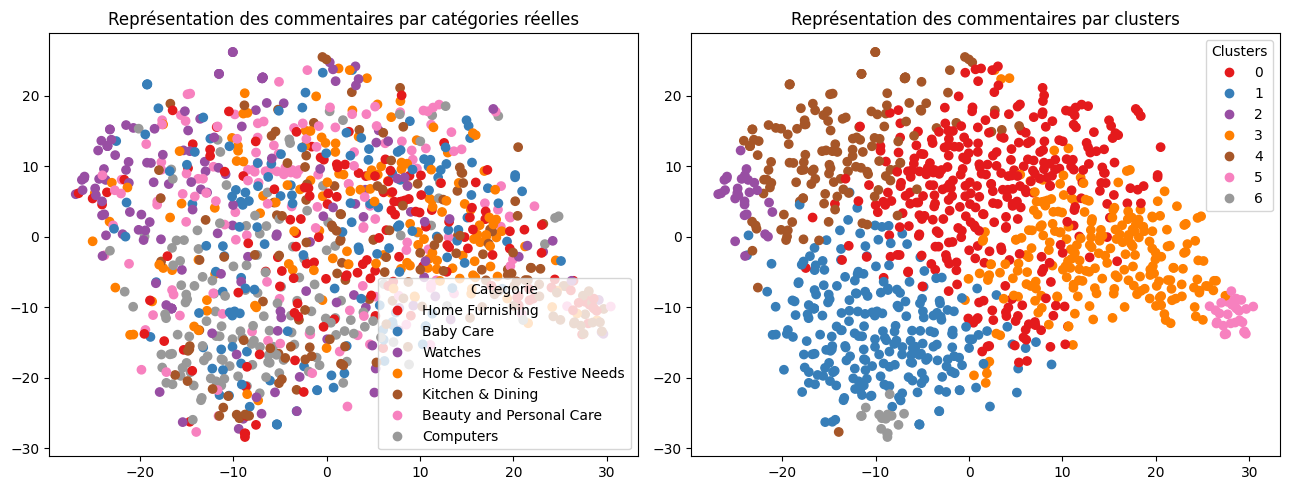

In [208]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(best_pca_vector)
print("ARI : ", max_ari, "Dimension du vecteur: ", best_pca_vector.shape[1])
compare_cluster_and_cat(X_tsne, best_labels, image_df['class'])

## **Modèles CNN**

Pour les modèles CNN, je vais utiliser des modèles pré-entrainés sur ImageNet pour extraire les vecteurs de caractéristiques des images.<br>
Je vais utiliser les modèles suivants:
- **VGG16**
- **ResNet50**
- **InceptionV3**
- **EfficientNetB0**

Je vais extraire les vecteurs de caractéristiques des images pour chaque modèle et ensuite les segmenter en utilisant les mêmes algorithmes de clustering non supervisée.<br>
Chaque modèle a sa propre fonction de prétraitement des images pour les recevoir sous le bon format.<br>
Notons aussi que chaque image est redimensionnée à la taille d'entrée du modèle.<br>

In [214]:
def extract_embeddings(model: Model, images: pd.Series, path: str, preprocess_input: callable) -> np.ndarray:
    # Récupère la taille d'entrée du modèle
    input_shape = model.input.shape
    input_size = (input_shape[1], input_shape[2])
    print(f"Input size: {input_size}")
    
    # Sélectionne la dernière couche du modèle pour l'extraction des embeddings
    last_layer = model.layers[-2]
    model = Model(inputs=model.inputs, outputs=last_layer.output)
    
    # Initialise une liste pour stocker les embeddings des images
    images_embeddings = []
    
    # Itère sur chaque image pour extraire les embeddings
    for img in images:
        clear_output()
        
        # Charge l'image depuis le chemin spécifié
        image = cv2.imread(path + img)
        
        # Redimensionne l'image à la taille d'entrée du modèle
        image = cv2.resize(image, input_size)
        
        # Ajoute une dimension supplémentaire pour correspondre à l'entrée du modèle
        image = np.expand_dims(image, axis=0)
        
        # Applique la fonction de prétraitement spécifique au modèle
        image = preprocess_input(image)
        
        # Prédit les embeddings de l'image en utilisant le modèle
        image_embedding = model.predict(image)
        
        # Ajoute les embeddings de l'image à la liste
        images_embeddings.append(image_embedding)
    
    # Convertit la liste des embeddings en un tableau numpy
    images_embeddings = np.asarray(images_embeddings)
    
    return images_embeddings

In [221]:
def ARI_cnn(images, embeddings, n_clusters=7):
    # Affiche la taile des embeddings
    print('Raw shape: ', embeddings.shape)
    embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
    print('Flat shape: ', embeddings_flat.shape)

    # Réduction de la dimensionnalité des embeddings avec un seuil de 95% de la variance expliquée
    pca = PCA(n_components=0.95)

    # Fit et transforme les embeddings
    embeddings_pca = pca.fit_transform(embeddings_flat)
    # Affiche la taille des embeddings après PCA
    print('PCA shape: ', embeddings_pca.shape)

    # Calcul de l'ARI, les données réduites et les clusters
    ari, X_tsne, clusters = compute_ari(embeddings_pca, images)

    return ari, X_tsne, clusters, embeddings_pca.shape[1]

### **VGG16**

Je commence avec le modèle préeentrainé VGG16.<br>
Il s'agit d'un modèle très populaire pour la classification d'images et son gros désavantage est qu'il est très lourd en termes de calculs.<br>
Son architecture est très simple avec des couches de convolution et de pooling.<br>


VGG16 prends en entrée des images de 224x224 pixels.<br>


**Je vais extraire à partir de l'avant dernière couche, située avant la couche de classification, les vecteurs de caractéristiques des images.**<br>
Cela retournera pour chaque image un vecteur de dimension propre à VGG16.<br>

In [222]:
embeddings = extract_embeddings(VGG16(), image_df['image'], path, vgg16_preprocess_input)
ari, x_tsne, clusters, vector_size = ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Raw shape:  (1050, 1, 4096)
Flat shape:  (1050, 4096)
PCA shape:  (1050, 480)


Modèle: VGG16  - ARI :  0.3956  - Dimension avant réduction:  4096  - Dimension après réduction PCA:  480


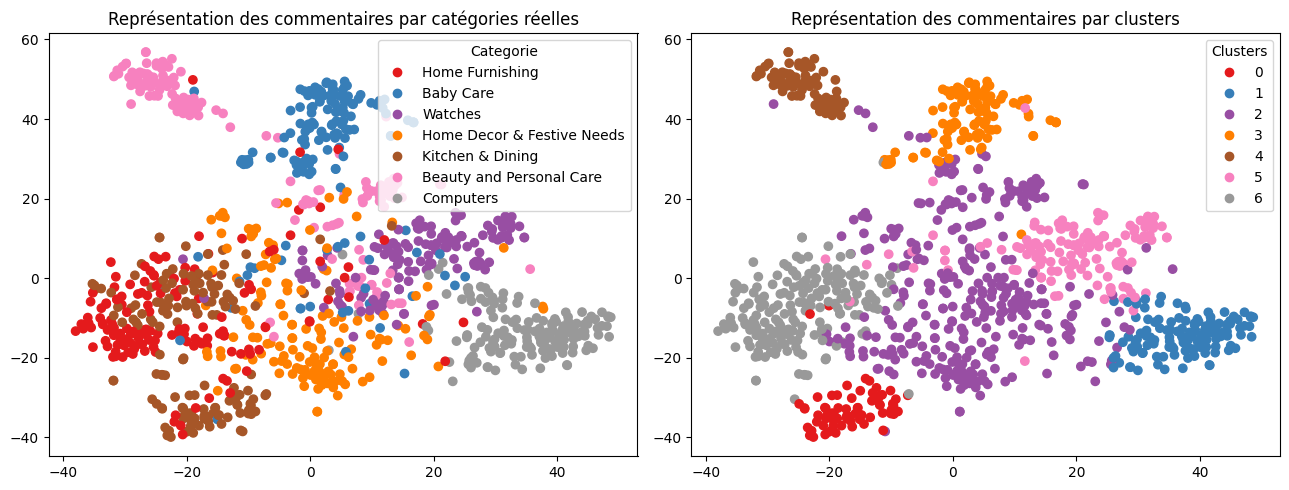

In [226]:
print('Modèle: VGG16', ' - ARI : ', ari, ' - Dimension avant réduction: ', embeddings.squeeze().shape[1], ' - Dimension après réduction PCA: ', vector_size)
compare_cluster_and_cat(x_tsne, clusters, image_df['class'])

D'entrée VGG16 a un score ARI élevé et prometteur.<br>
Sur la visualition, on note quelques zones d'hétérogénité au niveau de la séparation des catégories sur nos embeddings.<br>
On le voit par exemple avec `Home Furnishing` et `Kitchen & Dining` qui se chevauchent.<br>
Hormis ces 2 catégories problématiques, les autres semblent bien séparées.<br>


In [227]:
# Ajoute les scores à la liste
ari_scores.append(("VGG16", vector_size, ari))

### **RESNET50**

Je continue avec le modèle ResNet50.<br>
ResNet50 est un modèle plus profond que VGG16 et il a été conçu pour résoudre le problème du vanishing gradient.<br>
Il a une architecture plus complexe avec des connexions résiduelles.<br>
ResNet50 prend en entrée des images de 224x224 pixels.<br>

**Je vais extraire à partir de l'avant dernière couche, située avant la couche de classification, les vecteurs de caractéristiques des images.**<br>
Cela retournera pour chaque image un vecteur de dimension propre à ResNet50.<br>

In [228]:
embeddings = extract_embeddings(ResNet50(), image_df['image'], path, resnet50_preprocess_input)
ari, x_tsne, clusters, vector_size = ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Raw shape:  (1050, 1, 2048)
Flat shape:  (1050, 2048)
PCA shape:  (1050, 412)


Modèle: RESNET50  - ARI :  0.4247  - Dimension avant réduction:  2048  - Dimension après réduction PCA:  412


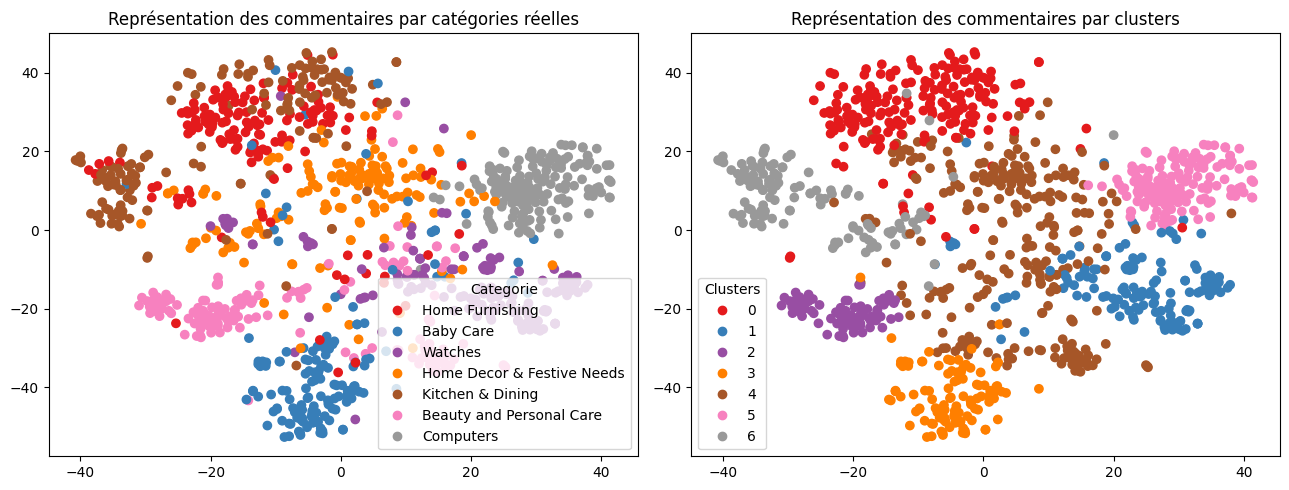

In [229]:
print('Modèle: RESNET50', ' - ARI : ', ari, ' - Dimension avant réduction: ', embeddings.squeeze().shape[1], ' - Dimension après réduction PCA: ', vector_size)
compare_cluster_and_cat(x_tsne, clusters, image_df['class'])

Le score ARI est légèrement plus élevé que celui de VGG16.<br>
On a toujours le même problème de chevauchement entre `Home Furnishing` et `Kitchen & Dining` mais de manière moins prononcée.<br>

In [230]:
# Ajoute les scores à la liste
ari_scores.append(("RESNET50", vector_size, ari))

### **INCEPTIONV3**

Le modèle InceptionV3 est un modèle plus récent que VGG16 et ResNet50.<br>
Il a été conçu pour être plus léger en termes de calculs et plus performant.<br>
Il a une architecture plus complexe avec des branches parallèles.<br>
InceptionV3 prend en entrée des images de 299x299 pixels.<br>

**Je vais extraire à partir de l'avant dernière couche, située avant la couche de classification, les vecteurs de caractéristiques des images.**<br>
Cela retournera pour chaque image un vecteur de dimension propre à InceptionV3.<br>

In [231]:
embeddings = extract_embeddings(InceptionV3(), image_df['image'], path, inception_v3_preprocess_input)
ari, x_tsne, clusters, vector_size = ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Raw shape:  (1050, 1, 2048)
Flat shape:  (1050, 2048)
PCA shape:  (1050, 411)


Modèle: INCEPTIONV3  - ARI :  0.4108  - Dimension avant réduction:  2048  - Dimension après réduction PCA:  411


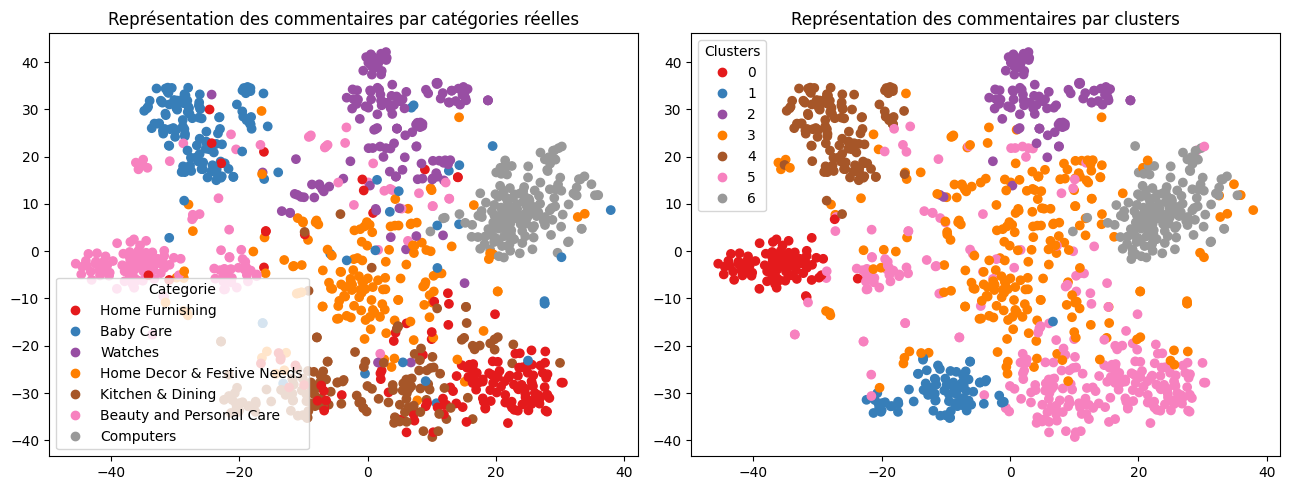

In [232]:
print('Modèle: INCEPTIONV3', ' - ARI : ', ari, ' - Dimension avant réduction: ', embeddings.squeeze().shape[1], ' - Dimension après réduction PCA: ', vector_size)
compare_cluster_and_cat(x_tsne, clusters, image_df['class'])

Les résultats sont très similaires à ceux de ResNet50.<br>

In [233]:
# Ajoute les scores à la liste
ari_scores.append(("INCEPTIONV3", vector_size, ari))

### **EFFICIENTNETB0**

Pour finir, je vais utiliser le modèle EfficientNetB0.<br>
EfficientNetB0 est un modèle plus récent que les précédents et il a été conçu pour être plus léger en termes de calculs et plus performant.<br>
Il a une architecture plus complexe avec des blocs de convolution et de pooling.<br>
EfficientNetB0 prend en entrée des images de 224x224 pixels.<br>

**Je vais extraire à partir de l'avant dernière couche, située avant la couche de classification, les vecteurs de caractéristiques des images.**<br>
Cela retournera pour chaque image un vecteur de dimension propre à EfficientNetB0.<br>

In [234]:
embeddings = extract_embeddings(EfficientNetB0(), image_df['image'], path, efficientnet_preprocess_input)
ari, x_tsne, clusters, vector_size = ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Raw shape:  (1050, 1, 1280)
Flat shape:  (1050, 1280)
PCA shape:  (1050, 416)


Modèle: EFFICIENTNETB0  - ARI :  0.5372  - Dimension avant réduction:  1280  - Dimension après réduction PCA:  416


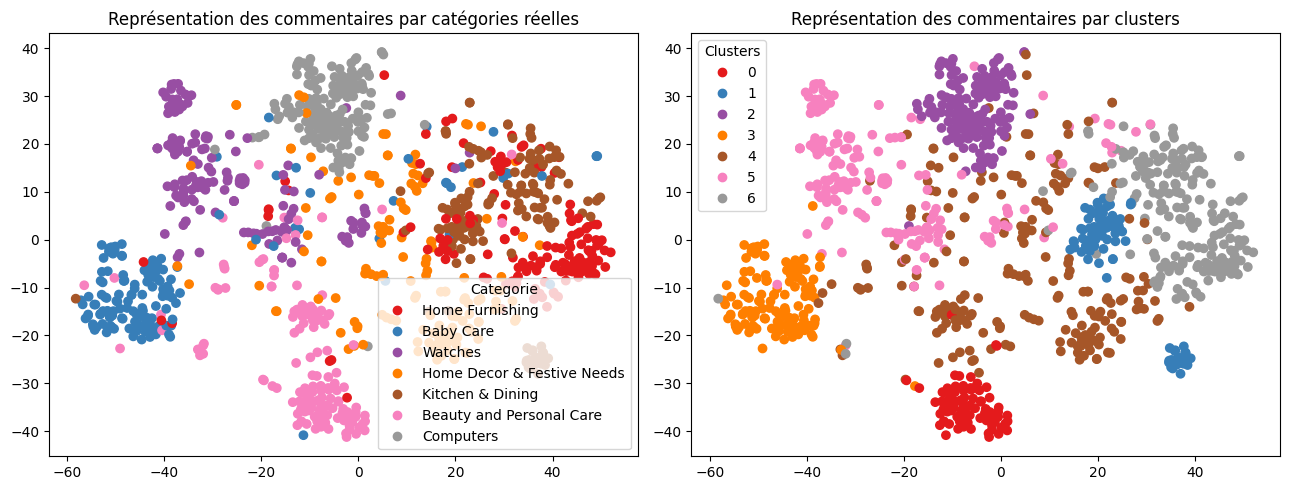

In [235]:
print('Modèle: EFFICIENTNETB0', ' - ARI : ', ari, ' - Dimension avant réduction: ', embeddings.squeeze().shape[1], ' - Dimension après réduction PCA: ', vector_size)
compare_cluster_and_cat(x_tsne, clusters, image_df['class'])

Les résultats sont meilleurs et on a un score ARI plus élevé que les précédents modèles.<br>
On note toujours un chevauchement entre `Home Furnishing` et `Kitchen & Dining` mais de manière moins prononcée.<br>
On suspecte que certaines images de ces catégories sont très similaires et que les modèles ont du mal à les distinguer.<br>
Un entraînement basée sur la classification d'images aidera le modèle a mieux séparer ces catégories.<br>

In [236]:
# Ajoute les scores à la liste
ari_scores.append(("EFFICIENTNETB0", vector_size, ari))

# **Comparaison des résultats**

Passons à la revue sur les résultats des différents modèles:

In [239]:
model_results_df = pd.DataFrame(ari_scores, columns=['model', 'vector_size', 'ARI'])
model_results_df = model_results_df.sort_values('ARI', ascending=False)
model_results_df.reset_index(drop=True, inplace=True)
print(model_results_df)

            model  vector_size       ARI
0  EFFICIENTNETB0          416  0.537200
1        RESNET50          412  0.424700
2     INCEPTIONV3          411  0.410800
3           VGG16          480  0.395600
4            SIFT           64  0.056942
5            SIFT          195  0.051406
6            SIFT          432  0.022032
7            SIFT          529  0.017306
8            SIFT          318  0.016902


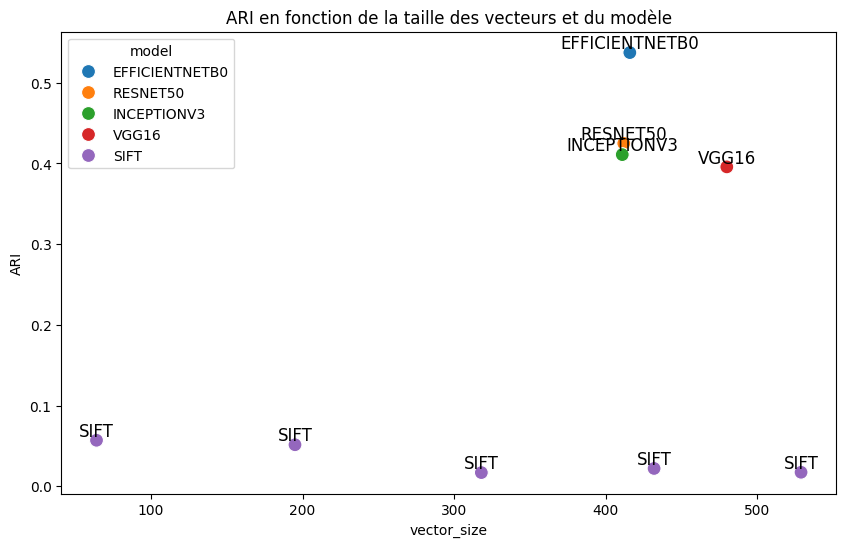

In [240]:
# Réaliser un scatter plot avec les ARI et la taille des vecteurs et en ajoutant le nom du modèle au-dessus de chaque point
plt.figure(figsize=(10, 6))
sns.scatterplot(data=model_results_df, x='vector_size', y='ARI', hue='model', s=100)
for i, row in model_results_df.iterrows():
    plt.text(row['vector_size'], row['ARI'], row['model'], fontsize=12, ha='center', va='bottom')
plt.title("ARI en fonction de la taille des vecteurs et du modèle")
plt.show()

Les réseaux de neurones convolutionnels (CNN) ont donné de meilleurs résultats que SIFT avec VBOW.<br>
La plupart de ces modèles ont des scores assez proches et on note également une différence sur le poids et le temps de calcul des embeddings en fonction de l'architecture du modèle.<br>
EfficientNetB0 s'agit du modèle qui présente le meilleur compromis en terme de score, rapidité et légereté.<br>